In [160]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.5*0.8],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [93]:
%run '../util/webrtc_reader.py'
%run '../util/helper_functions.py'

In [94]:
datasets = ['th', 'th_jitter', 'lat', 'lat_jitter', 'loss']
data_dir = '/home/taveesh/Documents/Projects/vca-qoe-inference/data'
cross_validations = 1
tested_vcas = ['meet', 'teams', 'webex']
traces_available = False
timestamps_available = False
metrics = ['framesReceivedPerSecond']

In [95]:
model_name_lookup = {
        'IP/UDP ML': '{}_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'IP/UDP Heuristic': '{}_frame-lookback_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP ML': '{}_rtp_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP Heuristic': '{}_rtp_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original'
}

col_map = {
        '{}_{}': 'Prediction',
        '{}_gt': 'Ground Truth',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error'
}
feature_map = {
    'l_mean': 'Packet size mean', 'l_std': 'Packet size standard deviation', 'l_min': 'Packet size min', 'l_max': 'Packet size max', 'l_q1': 'Packet size 25th percentile',
    'l_q2': 'Packet size 50th percentile', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': 'Total number of packets', 'l_num_bytes': 'Total number of bytes', 
    'l_num_unique': 'Total number of unique packet sizes', 'l_num_rtx': 'Number of packet retransmissions','t_mean': 'Packet IAT mean', 
    't_std': 'Packet IAT standard deviation', 't_min': 'Packet IAT min', 't_max': 'Packet IAT max', 't_q1': 'Packet IAT 25th percentile',
    't_q2': 'Packet IAT 50th percentile', 't_q3': 'Packet IAT 75th percentile', 't_burst_count': 'Burst Count',
    't_num_pkts': 'Total number of packets', 't_et': 'Interval end time', 'num_rtx': 'Number of retransmissions',
    'vid_ts_unique': 'Number of unique RTP video timestamps', 'rtx_ts_unique': 'Number of unique RTP retransmission timestamps', 'vid_marker_sum': 'Marker bit sum for video packets', 'rtx_marker_sum': 'Marker bit sum for retransmitted packets',
    'common_vid_rtx_ts_unique': 'Number of unique RTP timestamps shared by video and RTx streams', 'ooo_seqno_vid': 'Number of out of order video sequence numbers', 'buffer_time_mean': 'Mean of expected frame playback time', 'buffer_time_std': 'Stdev of expected frame playback time' , 'buffer_time_min': 'Min of expected frame playback time', 'buffer_time_max': 'Max of expected frame playback time', 'buffer_time_q1': 'Q1 of expected frame playback time', 'buffer_time_q2': 'Q2 of expected frame playback time', 'buffer_time_q3': 'Q3 of expected frame playback time', 'n_pkt_diff_mean': 'Mean number of packets between first and last packet of a frame',  'n_pkt_diff_std': 'Stdev of number of packets between first and last packet of a frame',
    'n_pkt_diff_min': 'Min number of packets between first and last packet of a frame','n_pkt_diff_max': 'Max number of packets between first and last packet of a frame','n_pkt_diff_q1': 'Q1 of number of packets between first and last packet of a frame','n_pkt_diff_q2': 'Q2 of number of packets between first and last packet of a frame','n_pkt_diff_q3': 'Q3 of number of packets between first and last packet of a frame', 'rtp_lag_min': 'Min expected playback time lag','rtp_lag_max':'Max expected playback time lag',
    'rtp_lag_q1': 'Q1 of expected playback time lag','rtp_lag_q2': 'Playback time lag 50th percentile','rtp_lag_q3': 'Q3 of expected playback time lag','rtp_lag_mean': 'Mean expected playback time lag','rtp_lag_std': 'Stdev of expected playback time lag'
}
suffix_map = {
    'IP/UDP ML': 'ml',
    'IP/UDP Heuristic': 'frame-lookback',
    'RTP ML': 'rtp_ml',
    'RTP Heuristic': 'rtp'
}

In [96]:
def load_pkl(path):
    with open(path, 'rb') as fd:
        obj = pickle.load(fd)
    return obj

def get_call_logs(cv, vca, dataset):
    pref = data_dir+'/'+dataset+'_cv_splits'
    spl = load_pkl(pref + '/' +'cv_file_splits.pkl')
    cols=['pcap_file', 'csv_file', 'webrtc_file']
    if traces_available:
        cols += ['trace_file']
    if timestamps_available:
        cols += ['timestamp_file']
    df = pd.DataFrame(spl[cv-1][vca]['test'], columns=cols)
    return df

def load_intermediates(method):
    suffix = f'_{suffix_map[method]}'
    preds = []
    f_imp = {}
    for metric in metrics:
        for dataset in datasets:
            print('Metric:', metric)
            f_imp[metric] = {}
            if metric == 'frameHeight' and 'Heuristic' in method:
                continue
            for cv in range(1, cross_validations+1):
                pref = model_name_lookup[method].format(metric, dataset, cv) + '/' + model_name_lookup[method].format(metric, dataset, cv)
                experiment = pref+'.pkl'
                model = pref+'_vca_model.pkl'
                predictions = pref+'_predictions.pkl'
                ddir = data_dir + '/' + dataset
                exp = load_pkl(ddir+'_intermediates/'+experiment)
                mod = load_pkl(ddir+'_intermediates/'+model)
                pred = load_pkl(ddir+'_intermediates/'+predictions)
                f_imp[metric][cv] = {}
                for vca in tested_vcas:
                    df_logs = get_call_logs(cv, vca, dataset)
                    f_imp[metric][cv][vca] = (mod[vca].feature_importances if 'ML' in method else None)
                    for df in pred[vca]:
                        if df is None:
                            continue
                        pcap = df['file'].unique()[0]
                        dfl = df_logs[df_logs['pcap_file'] == pcap]
                        rdr = WebRTCReader(dfl['webrtc_file'].unique()[0], dataset)
                        df_webrtc = rdr.get_webrtc()
                        df['cross_val'] = cv
                        df['metric'] = metric
                        df['method'] = method
                        df['VCA'] = vca
                        df[f'deviation'] = df[metric+suffix] - df[f'{metric}_gt']
                        df[f'abs_deviation'] = abs(df['deviation'])
                        df_merged = pd.merge(df, df_webrtc, left_on='timestamp', right_on='ts')
                        df_merged['csv_file'] = dfl['csv_file'].unique()[0]
                        df_merged['webrtc_file'] = dfl['webrtc_file'].unique()[0]
                        if traces_available:
                            df_merged['trace_file'] = dfl['trace_file'].unique()[0]
                        if timestamps_available:
                            df_merged['timestamp_file'] = dfl['timestamp_file'].unique()[0]
                        # df_merged['trace_profile'] = '-'.join(os.path.basename(dfl['csv_file'].unique()[0])[:-4].split('-')[2:8])
                        df_merged = df_merged.rename(columns={'file': 'pcap_file', metric+suffix: 'Prediction', f'{metric}_gt': 'Ground Truth'})
                        preds.append(df_merged)
    df = pd.concat(preds, axis=0)
    return df, f_imp

In [97]:
rtp_ml, f_rtp_ml = load_intermediates('RTP ML')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [98]:
udp_ml, f_udp_ml = load_intermediates('IP/UDP ML')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [328]:
rtp_non_ml, f_rtp_non_ml = load_intermediates('RTP Heuristic')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [336]:
udp_non_ml, f_udp_non_ml = load_intermediates('IP/UDP Heuristic')

Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond
Metric: framesReceivedPerSecond


In [337]:
df = pd.concat([rtp_ml, udp_ml, rtp_non_ml, udp_non_ml], axis=0)

In [338]:
df.to_csv('imc_lab_results_net_conditions.csv', index=False)

# Overall Numbers

In [332]:
df = pd.read_csv('imc_lab_results_net_conditions.csv', index_col=None)

/home/taveesh/Documents/Projects/vca-qoe-inference/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [104]:
# df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
print('IP/UDP ML')
df_fps = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'IP/UDP ML')]
dfg = df_fps.groupby(['VCA', 'dataset'])['abs_deviation'].mean()
print(dfg.to_latex(float_format="%.2f"))

# df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
print('RTP ML')
df_fps = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'RTP ML')]
dfg = df_fps.groupby(['VCA', 'dataset'])['abs_deviation'].mean()
print(dfg.to_latex(float_format="%.2f"))
dfg.reset_index()
# df_fps = df[df['metric'] == 'bitrate']
# dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
# print('Bitrate')
# print(dfg.to_latex(float_format="%.2f"))
# df_fps = df[df['metric'] == 'frame_jitter']
# dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
# print('Frame Jitter')
# print(dfg.to_latex(float_format="%.2f"))

IP/UDP ML
\begin{tabular}{llr}
\toprule
      &           &  abs\_deviation \\
VCA & dataset &                \\
\midrule
meet & lat &           2.09 \\
      & lat\_jitter &           2.19 \\
      & loss &           3.68 \\
      & th &           1.27 \\
      & th\_jitter &           1.67 \\
teams & lat &           2.51 \\
      & lat\_jitter &           2.05 \\
      & loss &           6.64 \\
      & th &           1.56 \\
      & th\_jitter &           2.28 \\
webex & lat &           0.63 \\
      & lat\_jitter &           1.40 \\
      & loss &           2.01 \\
      & th &           1.45 \\
      & th\_jitter &           2.60 \\
\bottomrule
\end{tabular}

RTP ML
\begin{tabular}{llr}
\toprule
      &           &  abs\_deviation \\
VCA & dataset &                \\
\midrule
meet & lat &           1.34 \\
      & lat\_jitter &           1.56 \\
      & loss &           2.52 \\
      & th &           1.14 \\
      & th\_jitter &           1.55 \\
teams & lat &           2.38 \\
  

,VCA,dataset,abs_deviation
0,meet,lat,1.34
1,meet,lat_jitter,1.56
2,meet,loss,2.52
3,meet,th,1.14
4,meet,th_jitter,1.55
5,teams,lat,2.38
6,teams,lat_jitter,2.06
7,teams,loss,5.51
8,teams,th,1.71
9,teams,th_jitter,2.35


In [105]:
df1 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'th')]
df2 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'th_jitter')]
df3 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'lat')]
df4 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'lat_jitter')]
df5 = df[(df['method'] == 'IP/UDP ML') & (df['dataset'] == 'loss')]

In [342]:
labels = {'th': 'Mean Throughput [kbps]', 'th_jitter': 'Throughput stdev. [kbps]', 
         'lat': 'Mean Delay [ms]', 'lat_jitter': 'Delay stdev [ms]', 'loss': 'Packet Loss [%]'}

def get_net_params(csv_file):
    fname = os.path.basename(csv_file)[:-4]
    fname = fname.split('-')[-2]
    t = tuple(map(int, fname.split('_')))[:-1]
    return t

def get_boxplot(d, param):
    d_ = d[d['dataset'] == param]
    d_['VCA'] = d_['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
    d_['th'], d_['th_jitter'], d_['lat'], d_['lat_jitter'], d_['loss'] =  zip(*d_['csv_file'].map(get_net_params))
    plt.figure(figsize=(4, 2))
    plt.rcParams["figure.autolayout"] = True
    ax = sns.boxplot(d_, x = param, y = 'deviation', hue='VCA', whis=[10, 90], showfliers=False)
    plt.ylabel('FPS Error', fontsize=10)
    plt.xlabel(labels[param], fontsize=10)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
    plt.grid()
    plt.savefig(f'paper_plots/{param}_box_sensitivity.pdf', bbox_inches='tight')
    
def get_plot(d, param, method):
    d_ = d[d['dataset'] == param]
    d_['VCA'] = d_['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
    d_['th'], d_['th_jitter'], d_['lat'], d_['lat_jitter'], d_['loss'] =  zip(*d_['csv_file'].map(get_net_params))
    plt.figure(figsize=(4, 2))
    plt.rcParams["figure.autolayout"] = True
    ax = sns.lineplot(d_, x = param, y = 'abs_deviation', hue='VCA', marker='o', estimator='mean', errorbar='ci')
    plt.setp(ax.get_xticklabels(), rotation=-1, ha="left")
    plt.ylabel('MAE', fontsize=10)
    plt.xlabel(labels[param], fontsize=10)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
    if param == 'th':
        ticks = [100, 500, 1000, 2000, 4000]
    elif param == 'th_jitter':
        ticks = [0, 100, 500, 1000, 1500]
    elif param == 'lat':
        ticks = [50, 100, 200, 300, 400, 500]
    elif param == 'lat_jitter':
        ticks = range(10, 110, 10)
    elif param == 'loss':
        ticks = [1,2,5,10,20]
    plt.ylim([0, 10])
    plt.xticks(ticks)
    plt.grid()
    plt.savefig(f'paper_plots/{param}_{method}_line_sensitivity.pdf', bbox_inches='tight')

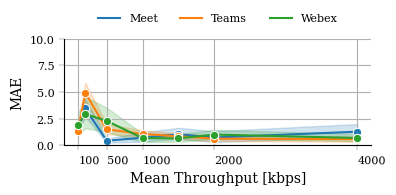

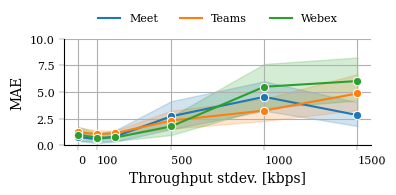

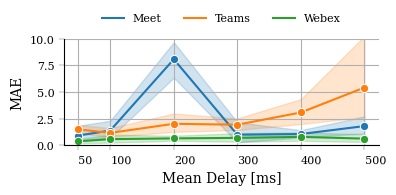

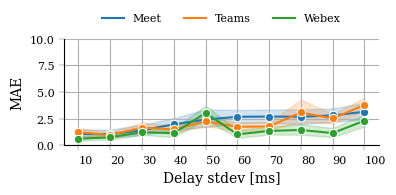

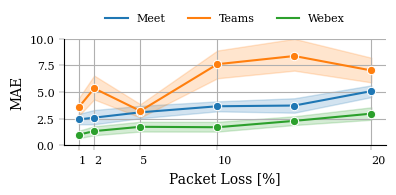

In [343]:
d = df[df['method'] == 'IP/UDP ML']
get_plot(d, 'th', 'ipml')
get_plot(d, 'th_jitter', 'ipml')
get_plot(d, 'lat', 'ipml')
get_plot(d, 'lat_jitter', 'ipml')
get_plot(d, 'loss', 'ipml')

# get_boxplot(d, 'th')
# get_boxplot(d, 'th_jitter')
# get_boxplot(d, 'lat')
# get_boxplot(d, 'lat_jitter')
# get_boxplot(d, 'loss')

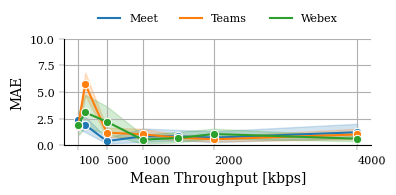

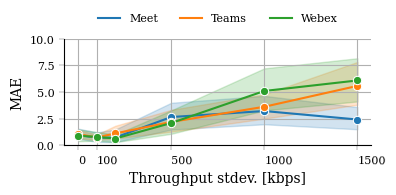

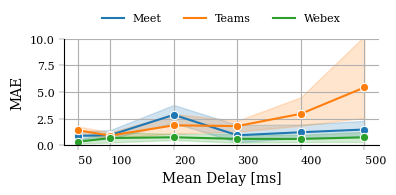

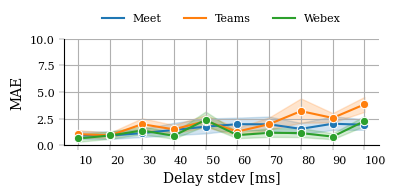

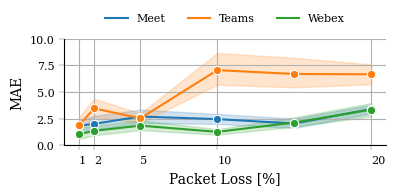

In [344]:
d = df[df['method'] == 'RTP ML']
get_plot(d, 'th', 'rtpml')
get_plot(d, 'th_jitter', 'rtpml')
get_plot(d, 'lat', 'rtpml')
get_plot(d, 'lat_jitter', 'rtpml')
get_plot(d, 'loss', 'rtpml')

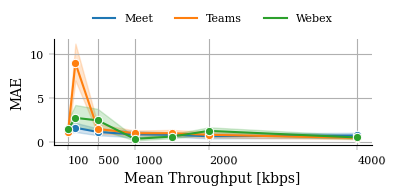

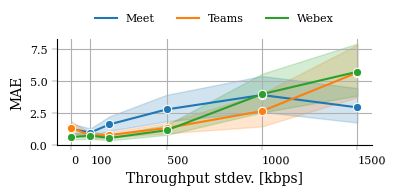

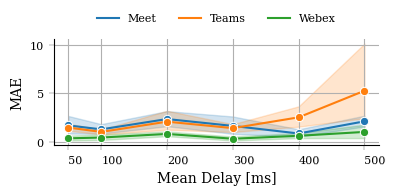

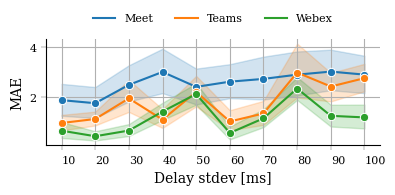

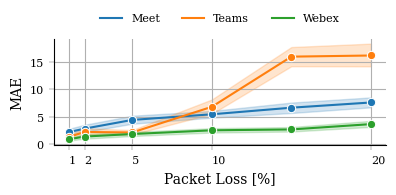

In [333]:
d = df[df['method'] == 'RTP Heuristic']
get_plot(d, 'th')
get_plot(d, 'th_jitter')
get_plot(d, 'lat')
get_plot(d, 'lat_jitter')
get_plot(d, 'loss')

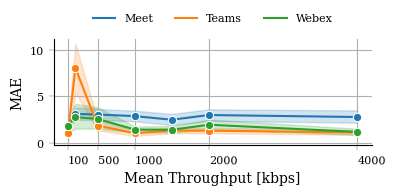

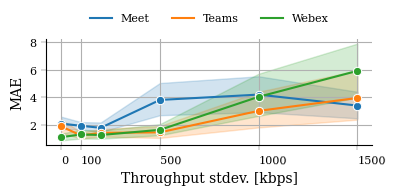

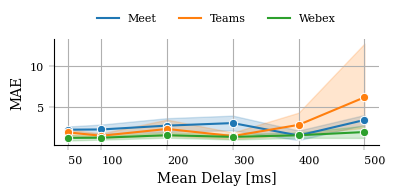

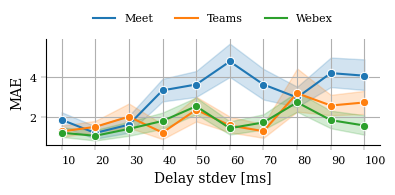

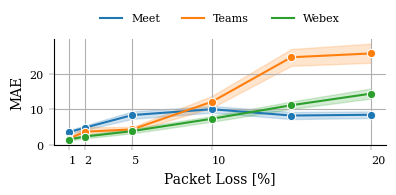

In [339]:
d = df[df['method'] == 'IP/UDP Heuristic']
get_plot(d, 'th')
get_plot(d, 'th_jitter')
get_plot(d, 'lat')
get_plot(d, 'lat_jitter')
get_plot(d, 'loss')